In [ ]:
import pandas as pd
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from utils import calc_confusion_matrix

In [10]:
data = pd.read_csv('data/raw_coordinates.txt', sep='\t')

In [11]:
# REMOVE H AND K
filtro = [c in ['Fr', 'Le', 'Me', 'Pa', 'Ma'] for c in data['Cultivar']]
data = data[filtro]

Train set: (361, 26), (361,)
Test set: (156, 26), (156,)
---
 TRAIN AND TEST: QDA
Accuracy: 0.7179

 Classification report:
              precision    recall  f1-score   support

          Fr       0.62      0.52      0.57        29
          Le       0.53      0.79      0.64        29
          Ma       0.73      0.77      0.75        39
          Me       0.88      0.74      0.81        31
          Pa       0.95      0.75      0.84        28

    accuracy                           0.72       156
   macro avg       0.75      0.71      0.72       156
weighted avg       0.75      0.72      0.72       156



/Users/pablo1n7/miniconda3/envs/cannabis/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


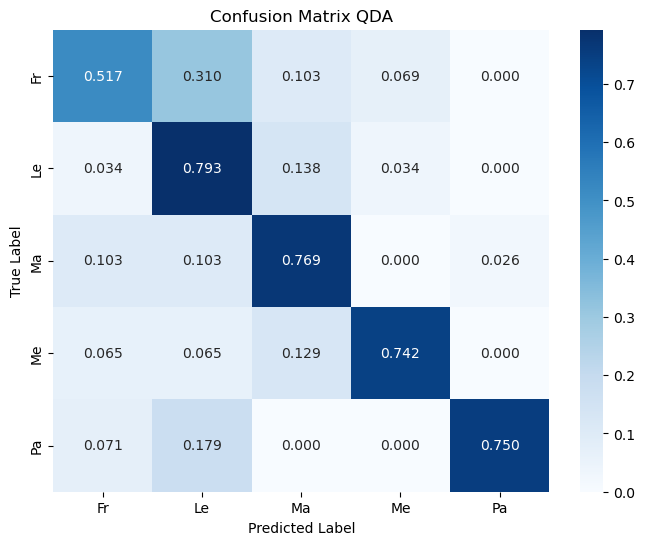

 TRAIN AND TEST: Random Forest
Accuracy: 0.7692

 Classification report:
              precision    recall  f1-score   support

          Fr       0.75      0.83      0.79        29
          Le       0.65      0.59      0.62        29
          Ma       0.78      0.82      0.80        39
          Me       0.81      0.84      0.83        31
          Pa       0.84      0.75      0.79        28

    accuracy                           0.77       156
   macro avg       0.77      0.76      0.76       156
weighted avg       0.77      0.77      0.77       156



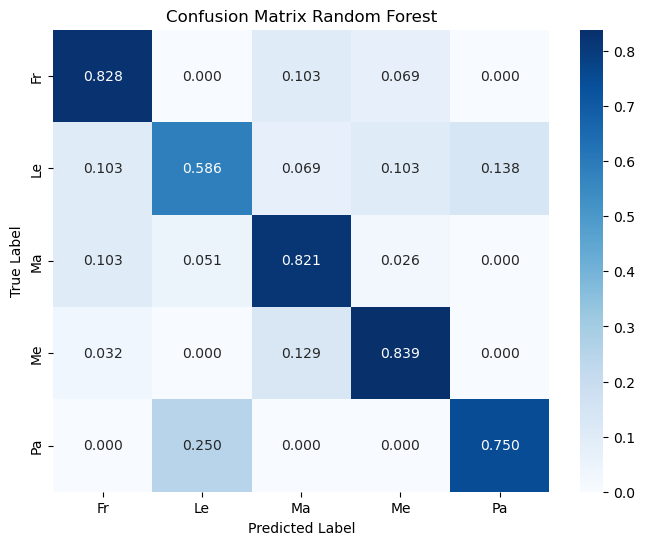

 TRAIN AND TEST: Decision Tree
Accuracy: 0.6987

 Classification report:
              precision    recall  f1-score   support

          Fr       0.79      0.66      0.72        29
          Le       0.49      0.59      0.53        29
          Ma       0.73      0.82      0.77        39
          Me       0.83      0.81      0.82        31
          Pa       0.70      0.57      0.63        28

    accuracy                           0.70       156
   macro avg       0.71      0.69      0.69       156
weighted avg       0.71      0.70      0.70       156



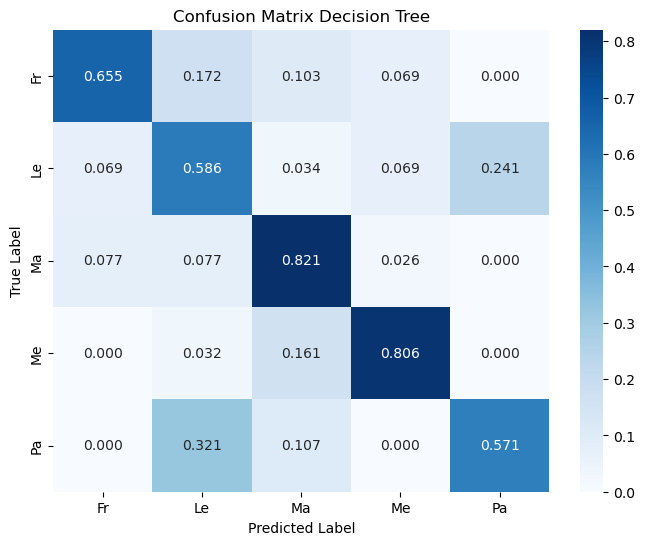

 TRAIN AND TEST: Naive Bayes
Accuracy: 0.7564

 Classification report:
              precision    recall  f1-score   support

          Fr       0.77      0.83      0.80        29
          Le       0.59      0.59      0.59        29
          Ma       0.77      0.77      0.77        39
          Me       0.76      0.81      0.78        31
          Pa       0.92      0.79      0.85        28

    accuracy                           0.76       156
   macro avg       0.76      0.76      0.76       156
weighted avg       0.76      0.76      0.76       156



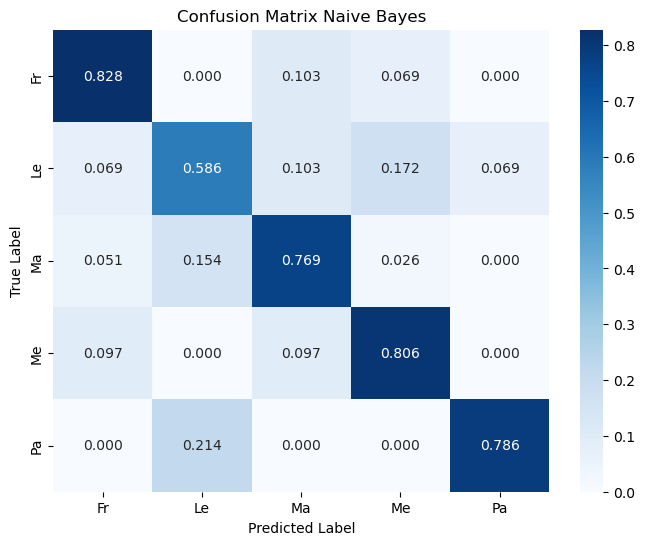

In [12]:
X_train_df, X_test_df = train_test_split(
    data, test_size=0.30, random_state=42, stratify=data['Cultivar'])

target_column = 'Cultivar'
feature_columns = data.columns[2:] 

# train set
x_train = X_train_df[feature_columns].to_numpy()
y_train = X_train_df[target_column].to_numpy()

# test set
x_test = X_test_df[feature_columns].to_numpy()
y_test = X_test_df[target_column].to_numpy() # Esta será tu 'y_test' real

print(f"Train set: {x_train.shape}, {y_train.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")
print("---")


classifiers = {
    "QDA": QuadraticDiscriminantAnalysis(),
    "Random Forest": RandomForestClassifier(max_depth=5, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Naive Bayes": GaussianNB()
}

results_summary = pd.DataFrame(columns=['Classifier', 'Test Accuracy'])

for name, clf in classifiers.items():
    
    print(f"=============================================")
    print(f" TRAIN AND TEST: {name}")
    print(f"=============================================")
    
    # Entrenar el clasificador
    clf.fit(x_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = clf.predict(x_test)
    
    # Calcular precisión (Accuracy)
    train_accuracy = clf.score(x_train, y_train)
    test_accuracy = clf.score(x_test, y_test)
    
    print(f"Accuracy: {test_accuracy:.4f}")
    
    # Guardar en el resumen
    results_summary.loc[len(results_summary)] = [name, test_accuracy]
    
    # Reporte de Clasificación
    print("\n Classification report:")
    print(classification_report(y_test, y_pred))
    

    calc_confusion_matrix(y_test, y_pred, clf.classes_, f'Confusion Matrix {name}', prefix='without_H_K')

In [13]:
print("=============================================")
print(" RESUME ACCURACY")
print("=============================================")


results_summary = results_summary.sort_values(by='Test Accuracy', ascending=False)

print(results_summary.to_string(index=False))

 RESUME ACCURACY
   Classifier  Test Accuracy
Random Forest       0.769231
  Naive Bayes       0.756410
          QDA       0.717949
Decision Tree       0.698718


In [14]:
print("=============================================")
print(" GRID SEARCH")
print("=============================================")


rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(x_train, y_train)

print("Best params:")
print(grid_search.best_params_)
print("---")

 GRID SEARCH
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
---


In [15]:
print("=============================================")
print(" EVALUATION: CLASSIFICATION REPORT")
print("=============================================")

best_rf = grid_search.best_estimator_

train_accuracy_tuned = best_rf.score(x_train, y_train)
test_accuracy_tuned = best_rf.score(x_test, y_test)

y_pred_tuned = best_rf.predict(x_test)
print(classification_report(y_test, y_pred_tuned))

 EVALUATION: CLASSIFICATION REPORT
              precision    recall  f1-score   support

          Fr       0.75      0.83      0.79        29
          Le       0.71      0.52      0.60        29
          Ma       0.76      0.82      0.79        39
          Me       0.82      0.87      0.84        31
          Pa       0.86      0.86      0.86        28

    accuracy                           0.78       156
   macro avg       0.78      0.78      0.78       156
weighted avg       0.78      0.78      0.78       156



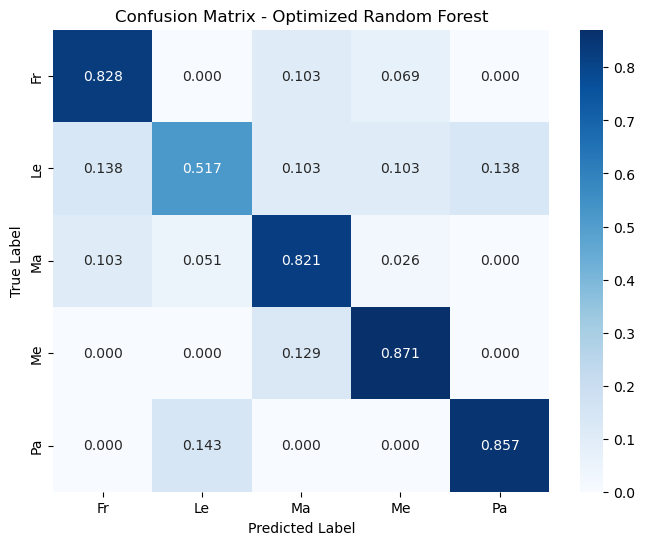

In [16]:
calc_confusion_matrix(y_test, y_pred_tuned, best_rf.classes_, title='Confusion Matrix - Optimized Random Forest', prefix='without_H_K')